### Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import applications
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, AUC,Recall
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
import copy
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.vgg19 import VGG19,preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory


In [27]:
!pip install git+https://github.com/jfilter/split-folders.git


  Cloning https://github.com/jfilter/split-folders.git to /tmp/pip-req-build-9dolnorg
  Running command git clone --filter=blob:none --quiet https://github.com/jfilter/split-folders.git /tmp/pip-req-build-9dolnorg
  Resolved https://github.com/jfilter/split-folders.git to commit c566dbd56a1097e1ddba2de5dfb93bd67eade54f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [28]:
import splitfolders

# Set the path of the directory containing the original images
input_folder = '/kaggle/input/alzheimer-mri-dataset/Dataset'

# Set the base directory for the split images
output_folder = '/kaggle/working/Splitted'

# Set the ratio of images for each split
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Use the splitfolders library to split the images into train-validation-test sets
splitfolders.ratio(input_folder, output_folder, seed=42,
                   ratio=(train_ratio,
                          validation_ratio,
                          test_ratio))


Copying files: 6400 files [00:08, 756.86 files/s] 


In [29]:
from keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16
IMG_SIZE = (128, 128)
SEED = 1345

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        )
       
validation_datagen = ImageDataGenerator(rescale=1./255)


test_datagen = ImageDataGenerator(rescale=1./255)

# Define directories for train, validation, and test sets
train_dir = '/kaggle/working/Splitted/train'
validation_dir = '/kaggle/working/Splitted/val'
test_dir = '/kaggle/working/Splitted/test'

# Define generators for train and validation sets using flow_from_directory
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size=64,
        class_mode ='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(128, 128),
        seed = SEED,
        shuffle=True,
        batch_size=64,
        class_mode ='categorical')

# Define generator for test set using flow_from_directory
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        shuffle=True,
        seed = SEED,
        batch_size =64,
        class_mode ='categorical')

epochs = 10

Found 5119 images belonging to 4 classes.
Found 639 images belonging to 4 classes.
Found 642 images belonging to 4 classes.


In [30]:
# class_names = train_generator.class_names
# class_names

class_names = list(train_generator.class_indices.keys())
class_names



['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

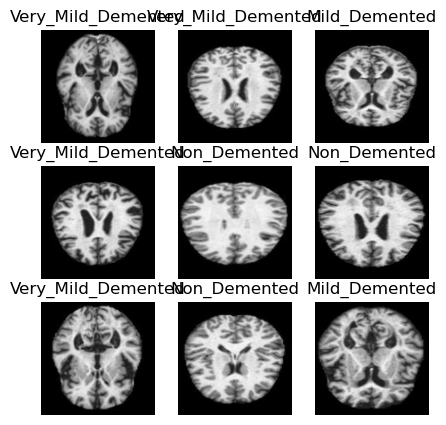

In [31]:
plt.figure(figsize=(5, 5))
for images, labels in train_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break


## Data Augmentation

In [32]:
#preprocessing for rotation and zoom
def data_augmentar():
   
    data_augmentation = Sequential()
    data_augmentation.add(RandomRotation(factor=(-0.15, 0.15)))
    data_augmentation.add(RandomZoom((-0.3, -0.1)))
    
    return data_augmentation

In [33]:
data_augmentation = data_augmentar()
assert(data_augmentation.layers[0].name.startswith('random_rotation'))
assert(data_augmentation.layers[0].factor == (-0.15, 0.15))
assert(data_augmentation.layers[1].name.startswith('random_zoom'))
assert(data_augmentation.layers[1].height_factor == (-0.3, -0.1))

## Solving Imbalanced Data Problem

In [34]:
## Calculate number of samples in each class.
input_folder = '/kaggle/input/alzheimer-mri-dataset/Dataset'
class_counts = dict()
for folder in class_names:
    class_counts[folder] = len(os.listdir(input_folder+'/'+folder))

class_counts

{'Mild_Demented': 896,
 'Moderate_Demented': 64,
 'Non_Demented': 3200,
 'Very_Mild_Demented': 2240}

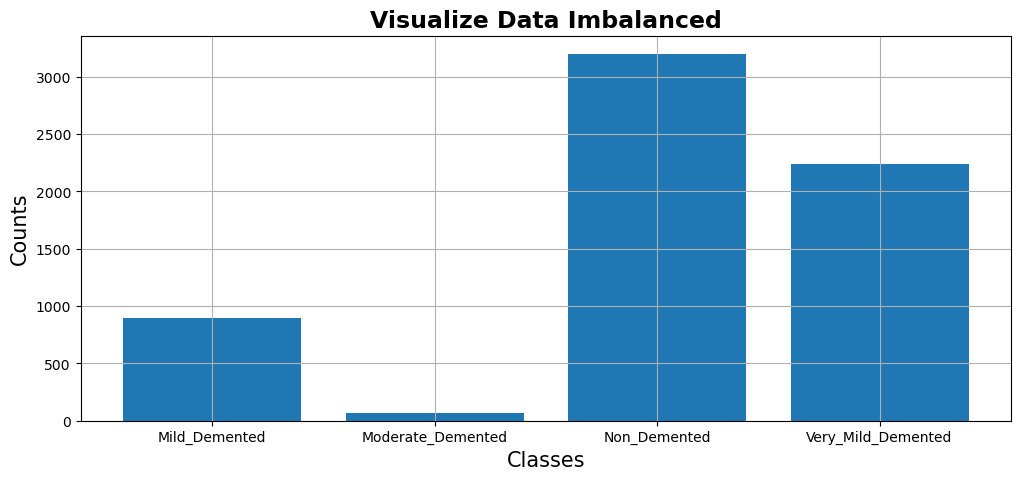

In [35]:
plt.figure(figsize=(12,5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes', fontdict={'fontsize':15})
plt.ylabel('Counts', fontdict={'fontsize':15})
plt.title('Visualize Data Imbalanced', fontdict={'fontsize':17,
                                                 'fontweight':'bold'})
plt.grid(True)
plt.show()

In [36]:
# Class_weight = (Total Number of images/Number of class x Images per class )

total = sum(class_counts.values())
number_of_classes = len([ 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented'])

class_weights = dict()
for i in range(number_of_classes):
    class_weights[i] = round(total / (number_of_classes * list(class_counts.values())[i]), 2)
    print(f'Weight for class \"{class_names[i]}\" : {class_weights[i]}')

Weight for class "Mild_Demented" : 1.79
Weight for class "Moderate_Demented" : 25.0
Weight for class "Non_Demented" : 0.5
Weight for class "Very_Mild_Demented" : 0.71


In [37]:
models=[]
acc=[]

### **VGG16**

In [38]:
# from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
# from keras.models import Model

# def VGG16():
#     input_layer = Input(shape=(128, 128, 3))

#     # Block 1
#     x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_layer)
#     x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#     # Block 2
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
#     x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#     # Block 3
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
#     x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#     # Block 4
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#     # Block 5
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
#     x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
#     x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

#     # Classification block
#     x = Flatten(name='flatten')(x)
#     x = Dense(4096, activation='relu', name='fc1')(x)
#     x = Dense(4096, activation='relu', name='fc2')(x)
#     x = Dense(1000, activation='softmax', name='predictions')(x)

#     model3 = Model(inputs=input_layer, outputs=x)
#     return model


In [39]:
base_model_3 = VGG16(input_shape=(128,128,3), 
                         include_top=False,
                         weights="imagenet")
for layer in base_model_3.layers:
  layer.trainable= False

In [40]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(4,activation='softmax')

model3 = tf.keras.Sequential([base_model_3, global_average_layer,
  keras.layers.BatchNormalization(),  
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])


In [41]:

model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model3.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)

Epoch 1/10
80/80 [==============================] - 25s 270ms/step - loss: 0.9437 - accuracy: 0.5491 - auc_1: 0.8304 - precision_1: 0.6230 - recall_1: 0.3993 - val_loss: 1.0167 - val_accuracy: 0.5728 - val_auc_1: 0.8394 - val_precision_1: 1.0000 - val_recall_1: 0.0282
Epoch 2/10
80/80 [==============================] - 22s 270ms/step - loss: 0.7797 - accuracy: 0.6382 - auc_1: 0.8868 - precision_1: 0.7002 - recall_1: 0.5364 - val_loss: 0.9909 - val_accuracy: 0.5086 - val_auc_1: 0.8327 - val_precision_1: 0.5731 - val_recall_1: 0.4538
Epoch 3/10
80/80 [==============================] - 22s 269ms/step - loss: 0.6973 - accuracy: 0.6913 - auc_1: 0.9106 - precision_1: 0.7450 - recall_1: 0.6097 - val_loss: 0.8796 - val_accuracy: 0.5994 - val_auc_1: 0.8687 - val_precision_1: 0.6749 - val_recall_1: 0.3834
Epoch 4/10
80/80 [==============================] - 22s 271ms/step - loss: 0.6298 - accuracy: 0.7255 - auc_1: 0.9279 - precision_1: 0.7667 - recall_1: 0.6620 - val_loss: 0.7543 - val_accuracy: 

In [42]:
models.append("VGG 16")
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 2048)              1050624   
                                                                 
 dense_7 (Dense)             (None, 512)               1049088   
                                                                 
 dense_8 (Dense)             (None, 256)              

In [43]:
result = model3.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

train_generator

80/80 [==============================] - 21s 259ms/step - loss: 0.2997 - accuracy: 0.8816 - auc_1: 0.9826 - precision_1: 0.8924 - recall_1: 0.8728
Train Loss = 0.29971858859062195
Train Accuracy = 0.8816174864768982
Train AUC = 0.9825676679611206
Train Precision = 0.8923507332801819
Train Recall = 0.8728266954421997


In [44]:
filepath = './Vgg_best_weights.hdf5'
# Stop the model when accuracy is not improving
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)
# Finding point where accuracy differs more
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [45]:
history3=model3.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=32)

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8125 - auc_1: 0.9749 - precision_1: 0.8175 - recall_1: 0.8047
Epoch 1: val_accuracy improved from -inf to 0.87167, saving model to ./Vgg_best_weights.hdf5
2/2 [==============================] - 2s 1s/step - loss: 0.3668 - accuracy: 0.8125 - auc_1: 0.9749 - precision_1: 0.8175 - recall_1: 0.8047 - val_loss: 0.3427 - val_accuracy: 0.8717 - val_auc_1: 0.9774 - val_precision_1: 0.8722 - val_recall_1: 0.8545
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.3183 - accuracy: 0.8906 - auc_1: 0.9809 - precision_1: 0.9098 - recall_1: 0.8672
Epoch 2: val_accuracy improved from 0.87167 to 0.88419, saving model to ./Vgg_best_weights.hdf5
2/2 [==============================] - 2s 1s/step - loss: 0.3183 - accuracy: 0.8906 - auc_1: 0.9809 - precision_1: 0.9098 - recall_1: 0.8672 - val_loss: 0.2958 - val_accuracy: 0.8842 - val_auc_1: 0.9839 - val_precision_1: 0.8885 - val_recall_1: 0.8732
Epoch 3/2

In [46]:
model3.evaluate(test_generator)

11/11 [==============================] - 1s 70ms/step - loss: 0.3334 - accuracy: 0.8863 - auc_1: 0.9789 - precision_1: 0.8884 - recall_1: 0.8801


[0.33336323499679565,
 0.8862928152084351,
 0.978877604007721,
 0.8883647918701172,
 0.8800622820854187]

In [47]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)



11/11 [==============================] - 1s 64ms/step - loss: 0.3334 - accuracy: 0.8863 - auc_1: 0.9789 - precision_1: 0.8884 - recall_1: 0.8801
Test Loss = 0.3333633244037628
Test Accuracy = 0.8862928152084351
Test AUC = 0.978877604007721
Test Precision = 0.8883647918701172
Test Recall = 0.8800622820854187


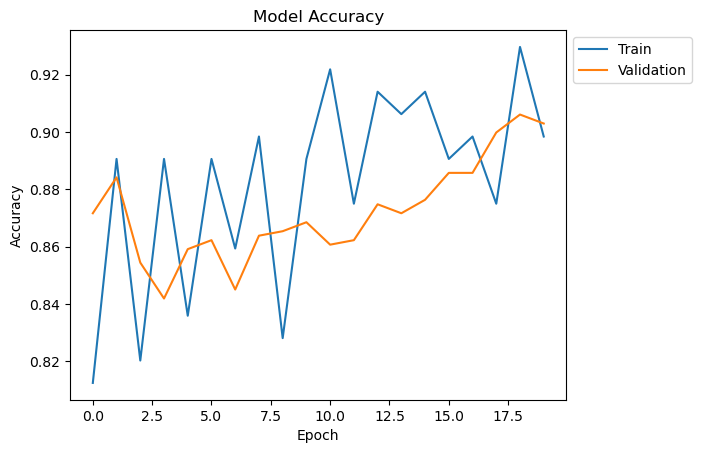

In [48]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

### ResNet50

In [49]:
base_model_2 = tf.keras.applications.ResNet50(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')
base_model_2.trainable = False


94765736/94765736 [==============================] - 3s 0us/step


In [50]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(4,activation='softmax')

model2 = tf.keras.Sequential([base_model_2, global_average_layer,
  keras.layers.BatchNormalization(),  
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])


In [51]:

model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model2.fit(train_generator,
                    validation_data= validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)


Epoch 1/10
80/80 [==============================] - 28s 288ms/step - loss: 0.9623 - accuracy: 0.5321 - auc_2: 0.8216 - precision_2: 0.6440 - recall_2: 0.3551 - val_loss: 1.1204 - val_accuracy: 0.5008 - val_auc_2: 0.8231 - val_precision_2: 0.5008 - val_recall_2: 0.5008
Epoch 2/10
80/80 [==============================] - 21s 259ms/step - loss: 0.8822 - accuracy: 0.5829 - auc_2: 0.8512 - precision_2: 0.6779 - recall_2: 0.4054 - val_loss: 1.0237 - val_accuracy: 0.5243 - val_auc_2: 0.8219 - val_precision_2: 0.6805 - val_recall_2: 0.3333
Epoch 3/10
80/80 [==============================] - 21s 267ms/step - loss: 0.8361 - accuracy: 0.6183 - auc_2: 0.8688 - precision_2: 0.6968 - recall_2: 0.4706 - val_loss: 1.0047 - val_accuracy: 0.5055 - val_auc_2: 0.8266 - val_precision_2: 0.7519 - val_recall_2: 0.3036
Epoch 4/10
80/80 [==============================] - 21s 267ms/step - loss: 0.7917 - accuracy: 0.6366 - auc_2: 0.8822 - precision_2: 0.7047 - recall_2: 0.5198 - val_loss: 0.8870 - val_accuracy: 

In [52]:
models.append("ResNet50")
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_2 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 2048)              4196352   
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dense_13 (Dense)            (None, 256)              

In [53]:
result = model2.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')


80/80 [==============================] - 21s 256ms/step - loss: 0.5029 - accuracy: 0.7867 - auc_2: 0.9540 - precision_2: 0.8125 - recall_2: 0.7443
Train Loss = 0.5028783679008484
Train Accuracy = 0.7866770625114441
Train AUC = 0.954010546207428
Train Precision = 0.8125399947166443
Train Recall = 0.7442860007286072


In [54]:
filepath = './Resnet50_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [55]:
history2=model2.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.7344 - auc_2: 0.9371 - precision_2: 0.7311 - recall_2: 0.6797
Epoch 1: val_accuracy improved from -inf to 0.70423, saving model to ./Resnet50_best_weights.hdf5
2/2 [==============================] - 2s 2s/step - loss: 0.5839 - accuracy: 0.7344 - auc_2: 0.9371 - precision_2: 0.7311 - recall_2: 0.6797 - val_loss: 0.7614 - val_accuracy: 0.7042 - val_auc_2: 0.9118 - val_precision_2: 0.7198 - val_recall_2: 0.6714
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.7266 - auc_2: 0.9393 - precision_2: 0.7480 - recall_2: 0.7188
Epoch 2: val_accuracy did not improve from 0.70423
2/2 [==============================] - 1s 1s/step - loss: 0.5722 - accuracy: 0.7266 - auc_2: 0.9393 - precision_2: 0.7480 - recall_2: 0.7188 - val_loss: 0.7459 - val_accuracy: 0.6776 - val_auc_2: 0.9108 - val_precision_2: 0.7061 - val_recall_2: 0.6541
Epoch 3/20
2/2 [==============================] -

In [56]:
model2.evaluate(test_generator)

11/11 [==============================] - 1s 61ms/step - loss: 0.6634 - accuracy: 0.7321 - auc_2: 0.9283 - precision_2: 0.7521 - recall_2: 0.7087


[0.6633713245391846,
 0.732087254524231,
 0.9283455610275269,
 0.7520661354064941,
 0.7087227702140808]

In [57]:
result = model2.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

11/11 [==============================] - 1s 52ms/step - loss: 0.6634 - accuracy: 0.7321 - auc_2: 0.9283 - precision_2: 0.7521 - recall_2: 0.7087
Test Loss = 0.6633712649345398
Test Accuracy = 0.732087254524231
Test AUC = 0.9283455610275269
Test Precision = 0.7520661354064941
Test Recall = 0.7087227702140808


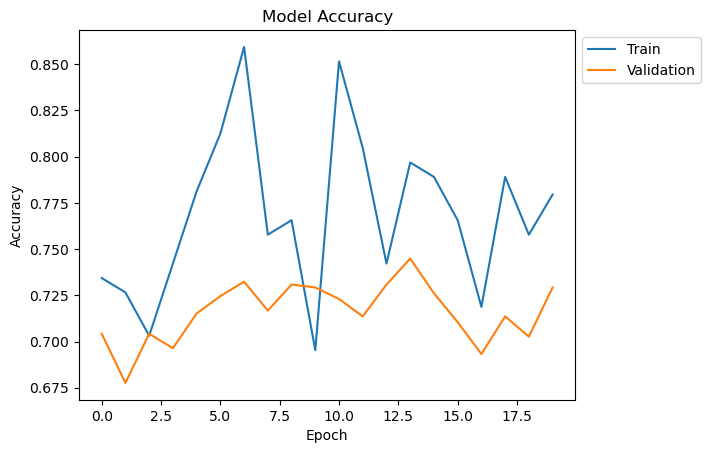

In [58]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## DenseNet169

In [59]:
base_model_4 = DenseNet169(input_shape=(128,128,3), 
                         include_top=False,
                         weights="imagenet")

51877672/51877672 [==============================] - 2s 0us/step


In [60]:
for layer in base_model_4.layers:
    layer.trainable=False

In [61]:

model=Sequential()
model.add(base_model_4)

model.add(Dropout(0.5))
model.add(Flatten()
)
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())

model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512,kernel_initializer='he_uniform'))

model.add(Dense(4,activation='softmax'))

In [62]:
models.append(model)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 4, 4, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 4, 4, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 26624)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 26624)            106496    
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 2048)              54528000  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [63]:
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)


Epoch 1/10


2023-05-01 19:42:37.663274: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


80/80 [==============================] - 38s 322ms/step - loss: 1.8178 - accuracy: 0.4938 - auc_3: 0.7650 - precision_3: 0.5066 - recall_3: 0.4735 - val_loss: 1.5790 - val_accuracy: 0.5462 - val_auc_3: 0.8112 - val_precision_3: 0.5440 - val_recall_3: 0.5227
Epoch 2/10
80/80 [==============================] - 22s 278ms/step - loss: 1.1804 - accuracy: 0.5433 - auc_3: 0.8172 - precision_3: 0.5665 - recall_3: 0.4993 - val_loss: 0.8779 - val_accuracy: 0.6307 - val_auc_3: 0.8712 - val_precision_3: 0.6755 - val_recall_3: 0.5603
Epoch 3/10
80/80 [==============================] - 22s 278ms/step - loss: 1.0104 - accuracy: 0.5900 - auc_3: 0.8466 - precision_3: 0.6139 - recall_3: 0.5370 - val_loss: 0.7099 - val_accuracy: 0.6901 - val_auc_3: 0.9077 - val_precision_3: 0.7431 - val_recall_3: 0.5931
Epoch 4/10
80/80 [==============================] - 22s 271ms/step - loss: 0.9008 - accuracy: 0.6240 - auc_3: 0.8670 - precision_3: 0.6561 - recall_3: 0.5657 - val_loss: 0.7096 - val_accuracy: 0.6901 - va

In [64]:
models.append("DenseNet169")
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 4, 4, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 4, 4, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 26624)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 26624)            106496    
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 2048)              54528000  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                      

In [65]:
result = model2.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

80/80 [==============================] - 21s 258ms/step - loss: 0.4785 - accuracy: 0.7968 - auc_2: 0.9589 - precision_2: 0.8240 - recall_2: 0.7593
Train Loss = 0.4784715473651886
Train Accuracy = 0.7968353033065796
Train AUC = 0.9589487910270691
Train Precision = 0.8240407109260559
Train Recall = 0.7593280076980591


In [66]:
filepath = './DenseNet169_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'auto' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='auto', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [67]:
history4 = model.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 20,callbacks = callback_list,
                        verbose = 1,batch_size=16)

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.7126 - accuracy: 0.7188 - auc_3: 0.9159 - precision_3: 0.7391 - recall_3: 0.6641
Epoch 1: val_accuracy improved from -inf to 0.80125, saving model to ./DenseNet169_best_weights.hdf5
2/2 [==============================] - 4s 3s/step - loss: 0.7126 - accuracy: 0.7188 - auc_3: 0.9159 - precision_3: 0.7391 - recall_3: 0.6641 - val_loss: 0.5027 - val_accuracy: 0.8013 - val_auc_3: 0.9541 - val_precision_3: 0.8287 - val_recall_3: 0.7496
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.6079 - accuracy: 0.7344 - auc_3: 0.9335 - precision_3: 0.7928 - recall_3: 0.6875
Epoch 2: val_accuracy did not improve from 0.80125
2/2 [==============================] - 1s 1s/step - loss: 0.6079 - accuracy: 0.7344 - auc_3: 0.9335 - precision_3: 0.7928 - recall_3: 0.6875 - val_loss: 0.5088 - val_accuracy: 0.7856 - val_auc_3: 0.9528 - val_precision_3: 0.8202 - val_recall_3: 0.7496
Epoch 3/20
2/2 [==============================

In [68]:
model.evaluate(test_generator)

11/11 [==============================] - 1s 99ms/step - loss: 0.5593 - accuracy: 0.7679 - auc_3: 0.9419 - precision_3: 0.7968 - recall_3: 0.7087


[0.5592952966690063,
 0.767912745475769,
 0.9419402480125427,
 0.7968476414680481,
 0.7087227702140808]

In [69]:
result = model3.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

11/11 [==============================] - 1s 50ms/step - loss: 0.3334 - accuracy: 0.8863 - auc_1: 0.9789 - precision_1: 0.8884 - recall_1: 0.8801
Test Loss = 0.33336329460144043
Test Accuracy = 0.8862928152084351
Test AUC = 0.978877604007721
Test Precision = 0.8883647918701172
Test Recall = 0.8800622820854187


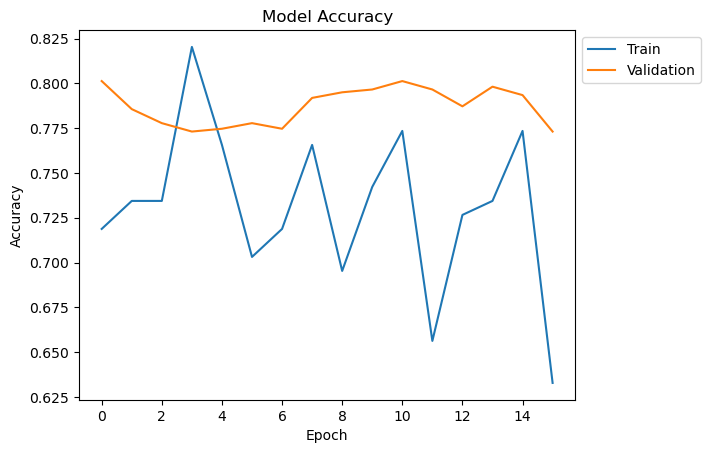

In [70]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## **INCEPTION V3**

In [71]:
from tensorflow.keras.applications import InceptionV3
base_model_6 = tf.keras.applications.InceptionV3(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')


87910968/87910968 [==============================] - 3s 0us/step


In [72]:
for layer in base_model_6.layers:
  layer.trainable=False

In [73]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = keras.layers.Dense(4,activation='softmax')

model4 = tf.keras.Sequential([base_model_6, global_average_layer,
  keras.layers.BatchNormalization(),  
  keras.layers.Dense(2048, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(64, activation='relu'),
  prediction_layer
])



In [74]:
model4.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy', 
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        ])


# Train your model with mixed precision
history = model4.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=len(train_generator),
                    epochs = epochs,
                    verbose=1)


Epoch 1/10
80/80 [==============================] - 29s 282ms/step - loss: 1.0022 - accuracy: 0.5347 - auc_4: 0.8178 - precision_4: 0.6021 - recall_4: 0.3999 - val_loss: 0.9395 - val_accuracy: 0.5540 - val_auc_4: 0.8438 - val_precision_4: 0.6082 - val_recall_4: 0.4617
Epoch 2/10
80/80 [==============================] - 21s 267ms/step - loss: 0.8705 - accuracy: 0.5950 - auc_4: 0.8570 - precision_4: 0.6592 - recall_4: 0.4470 - val_loss: 0.8530 - val_accuracy: 0.5806 - val_auc_4: 0.8571 - val_precision_4: 0.6637 - val_recall_4: 0.4664
Epoch 3/10
80/80 [==============================] - 21s 264ms/step - loss: 0.8375 - accuracy: 0.6056 - auc_4: 0.8677 - precision_4: 0.6877 - recall_4: 0.4823 - val_loss: 0.8168 - val_accuracy: 0.6009 - val_auc_4: 0.8714 - val_precision_4: 0.7007 - val_recall_4: 0.4507
Epoch 4/10
80/80 [==============================] - 21s 264ms/step - loss: 0.7803 - accuracy: 0.6402 - auc_4: 0.8852 - precision_4: 0.7008 - recall_4: 0.5362 - val_loss: 0.8298 - val_accuracy: 

In [75]:
result = model4.evaluate(train_generator)
train_loss = result[0]
train_accuracy = result[1]
train_AUC = result[2]
train_pre = result[3]
train_rec = result[4]
print(f'Train Loss = {train_loss}')
print(f'Train Accuracy = {train_accuracy}')
print(f'Train AUC = {train_AUC}')
print(f'Train Precision = {train_pre}')
print(f'Train Recall = {train_rec}')

80/80 [==============================] - 21s 261ms/step - loss: 0.6045 - accuracy: 0.7431 - auc_4: 0.9344 - precision_4: 0.7797 - recall_4: 0.6962
Train Loss = 0.6044960618019104
Train Accuracy = 0.7431138753890991
Train AUC = 0.9343894720077515
Train Precision = 0.7796980738639832
Train Recall = 0.6962297558784485


In [76]:
filepath = './InceptionV3_best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'auto' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='auto', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [77]:
history_6 = model4.fit(train_generator,
                        validation_data=validation_generator,
                        steps_per_epoch=len(train_generator)//32,
                        epochs = 20, callbacks = callback_list,
                        verbose = 1, batch_size=16)

Epoch 1/20
2/2 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.6953 - auc_4: 0.9184 - precision_4: 0.7391 - recall_4: 0.6641
Epoch 1: val_accuracy improved from -inf to 0.71049, saving model to ./InceptionV3_best_weights.hdf5
2/2 [==============================] - 2s 2s/step - loss: 0.6653 - accuracy: 0.6953 - auc_4: 0.9184 - precision_4: 0.7391 - recall_4: 0.6641 - val_loss: 0.6770 - val_accuracy: 0.7105 - val_auc_4: 0.9209 - val_precision_4: 0.7412 - val_recall_4: 0.6588
Epoch 2/20
2/2 [==============================] - ETA: 0s - loss: 0.4910 - accuracy: 0.7891 - auc_4: 0.9583 - precision_4: 0.8291 - recall_4: 0.7578
Epoch 2: val_accuracy did not improve from 0.71049
2/2 [==============================] - 1s 1s/step - loss: 0.4910 - accuracy: 0.7891 - auc_4: 0.9583 - precision_4: 0.8291 - recall_4: 0.7578 - val_loss: 0.6996 - val_accuracy: 0.7011 - val_auc_4: 0.9163 - val_precision_4: 0.7339 - val_recall_4: 0.6604
Epoch 3/20
2/2 [==============================

In [78]:
model4.evaluate(test_generator)

11/11 [==============================] - 1s 79ms/step - loss: 0.6879 - accuracy: 0.6900 - auc_4: 0.9127 - precision_4: 0.7183 - recall_4: 0.6355


[0.6878608465194702,
 0.6900311708450317,
 0.9126734733581543,
 0.7183098793029785,
 0.6355140209197998]

In [79]:
result = model4.evaluate(test_generator)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]

print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')
acc.append(test_accuracy*100)

11/11 [==============================] - 1s 54ms/step - loss: 0.6879 - accuracy: 0.6900 - auc_4: 0.9127 - precision_4: 0.7183 - recall_4: 0.6355
Test Loss = 0.687853217124939
Test Accuracy = 0.6900311708450317
Test AUC = 0.9126747250556946
Test Precision = 0.7183098793029785
Test Recall = 0.6355140209197998


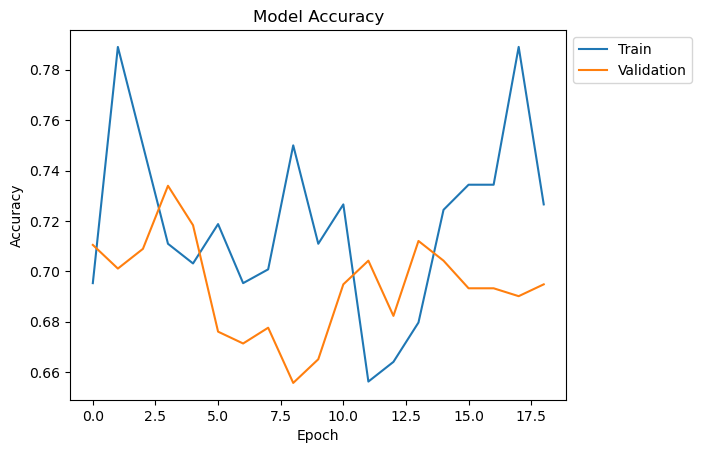

In [80]:
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

## **Prediction**

In [81]:
models1=["VGG","RESNET50","DensNET","Inception V3"]

In [82]:

print(models1)
print(acc)

['VGG', 'RESNET50', 'DensNET', 'Inception V3']
[88.6292815208435, 73.2087254524231, 88.6292815208435, 69.00311708450317]


1/1 [==============================] - 3s 3s/step
99.65 % chances are there that the image is Moderate_Demented


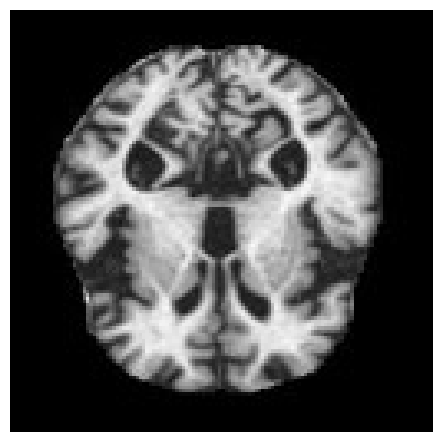

In [83]:
dic = test_generator.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('/kaggle/input/alzheimer-mri-dataset/Dataset/Moderate_Demented/moderate_19.jpg', target_size = (128,128,3))
img = img_to_array(img)
img = img/255

imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)

# answer = model.predict_classes(img)
predict_x=model2.predict(img) 
classes_x=np.argmax(predict_x,axis=1)

probability = round(np.max(model.predict(img)*100),2)
print(probability, '% chances are there that the image is',idc[classes_x[0]])

## **Accuracy Plot**

In [84]:
model3.save("vgg.h5")
model2.save("resnet.h5")
model.save("densenet.h5")
model4.save("inception.h5")

### **Streamlit Deployment**

In [85]:
max = acc[0];         
maxname = None
if len(acc) > 0:
    max = acc[0]
    maxname = models1[0]
    for i in range(1, len(models1)):
        if acc[i] > max:
            max = acc[i]
            maxname = models1[i]
if maxname == 'vgg':
    model3.save("vgg.h5")
    model3.load_weights("vgg.h5")
elif maxname == 'resnet':
  model2.save("resnet.h5")
  model2.load_weights("resnet.h5")
elif maxname == 'densenet':
  model.save("densenet.h5")
  model.load_weights("densenet.h5")
elif maxname == 'inception':
  model.save("inception.h5")
  model.load_weights("inception.h5")

print("Best Accuracy Model is "+maxname+" with accuracy of "+ str(max)); 
aa=maxname+'.h5'  

Best Accuracy Model is VGG with accuracy of 88.6292815208435


In [86]:
print(aa)

VGG.h5


In [87]:
tensorflow.keras.models.save_model(model,'VGG.h5')

In [88]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)

In [114]:
import tensorflow_cloud as tfc
import datetime

# Note: Please set GCP_PROJECT_ID to your own Google Cloud project ID.
GCP_PROJECT_ID = "alzheimersdementiaclassi"

# Note: Please set GCS_BUCKET to your own Google Cloud Storage (GCS) bucket.
GCS_BUCKET = 'alzheimernuck' # used to save models & docker images

# Note: Please change the job name to reflect the work you are doing.
JOB_NAME = 'kaggle-example'

if not tfc.remote():
    from kaggle_secrets import UserSecretsClient
    UserSecretsClient().set_gcloud_credentials(project=GCP_PROJECT_ID)

gcs_base_path = f'gs://{GCS_BUCKET}/{JOB_NAME}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'

Updated property [auth/credential_file_override].
Updated property [core/project].


In [115]:
MODEL_PATH = "/kaggle/working/VGG.h5"

model = tf.keras.models.load_model(MODEL_PATH)

In [116]:
!gcloud config set project 'alzheimersdementiaclassi'

Updated property [core/project].


In [ ]:
MODEL_NAME = 'alzheimer_vgg16try'

!gcloud ai-platform models create $MODEL_NAME --regions=us-central1


In [120]:
MODEL_VERSION = 'v1'
!gcloud ai-platform versions create $MODEL_VERSION \
    --model $MODEL_NAME \
    --origin $MODEL_PATH \
    --runtime-version=2.2 \
    --framework='tensorflow' \
    --python-version=3.7

Please specify a region:
(For the global endpoint the region needs to be specified as 'global'.)
 [1] global
 [2] asia-east1
 [3] asia-northeast1
 [4] asia-southeast1
 [5] australia-southeast1
 [6] europe-west1
 [7] europe-west2
 [8] europe-west3
 [9] europe-west4
 [10] northamerica-northeast1
 [11] us-central1
 [12] us-east1
 [13] us-east4
 [14] us-west1
 [15] cancel
Please enter your numeric choice:  ^C


Command killed by keyboard interrupt



In [ ]:
!pip install streamlit

In [ ]:
! pip install pyngrok

In [ ]:
from tensorflow.keras.utils import load_img,img_to_array

In [ ]:
%%writefile img_classification.py

from PIL import Image
from tensorflow.keras.utils import load_img,img_to_array
import numpy as np
import keras
from keras.models import load_model
from PIL import Image, ImageOps
def teachable_machine_classification(img, weights_file):
    
    model = keras.models.load_model(weights_file)

    
    data = np.ndarray(shape=(1, 128, 128, 3), dtype=np.float32)
    image = img
  
    size = (128, 128)
    image = ImageOps.fit(image, size, Image.ANTIALIAS)

  
    image_array = np.asarray(image)
  
    normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1

  
    data[0] = normalized_image_array

    prediction = model.predict(data)
    return np.argmax(prediction)

In [ ]:
import streamlit as st
from img_classification import teachable_machine_classification
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import keras

st.title("Demented and Non demented")
st.header("Alzheimer's disease Classification using MRI image data")
st.text("Upload a brain MRI Image for Alzheimer's disease")
     
uploaded_file = st.file_uploader("Choose an image...", type=["jpg","png","jpeg"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    st.write("Classifying...")
    
    st.write("")
    label = teachable_machine_classification(image, 'VGG.h5')
    if label == 0:
       st.write("Demented")
    else:
       st.write("Non demented")
        
        

In [ ]:
!ngrok authtoken 2OqGmlCopSt16uGRpgjkQVEorz9_6D6mrFEttopemHqSfYnoC

In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(8501)
public_url

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

In [ ]:
!unzip ngrok-stable-linux-amd64.zip 

In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \

In [ ]:
!streamlit run /kaggle/working/img_classification.py

In [ ]:

!streamlit run /kaggle/working/img_classification.py & npx localtunnel --port 8080 -y


